## **1. Data Preparation** 
#### Importing Libraries

In [38]:
import os
import random
import torch
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from torch.utils.data import (ConcatDataset, DataLoader, Dataset, Subset,
                              random_split)
from torchvision import datasets, transforms

### **1.1 Data Loading**

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

combined_dataset = ConcatDataset([train_dataset, test_dataset])

### **1.2 Data Preprocessing**

In [3]:
train_size = 42000
val_size = 14000
test_size = 14000

# Split the combined dataset
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 42000
Validation size: 14000
Test size: 14000


### **1.3 Data Analysis and Visualization**

#### 1.3.1 Sample Images - Visualization

In [5]:
def plot_samples(images, labels, class_names, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

class_names = [str(i) for i in range(10)]
N = 1000  # Num of images for correlation

Text(0.5, 0.98, 'Training Samples')

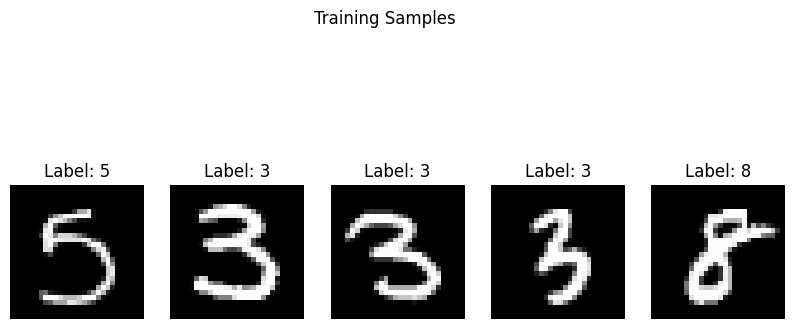

In [7]:
# plot training samples with labels
images, labels = zip(*[(image.numpy(), label) for image, label in [train_dataset[i] for i in range(N)]])
plot_samples(images, labels, class_names)
plt.suptitle('Training Samples')

Text(0.5, 0.98, 'Testing Samples')

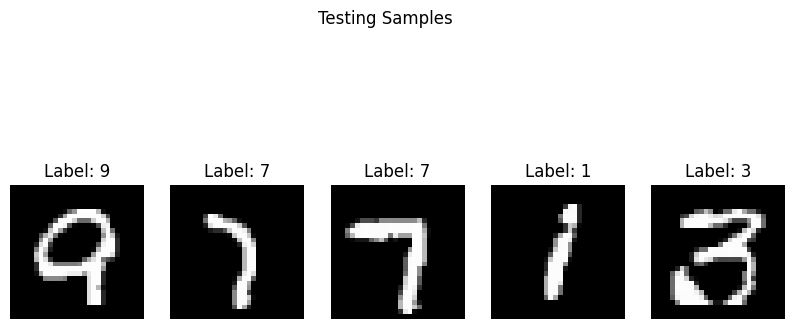

In [8]:
images, labels = zip(*[(image.numpy(), label) for image, label in [test_dataset[i] for i in range(N)]])
plot_samples(images, labels, class_names)
plt.suptitle('Testing Samples')

#### 1.3.2 Correlation Matrix of MNIST pixel values

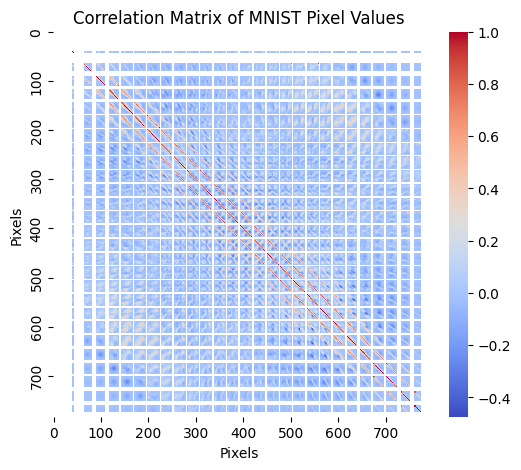

In [16]:
train_images = torch.stack([train_dataset[i][0] for i in range(N)])
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)])
train_images = train_images.view(N, -1).numpy()

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(train_images.T)

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, xticklabels=100, yticklabels=100)
plt.title('Correlation Matrix of MNIST Pixel Values')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

#### 1.3.3 Distribution of Digits

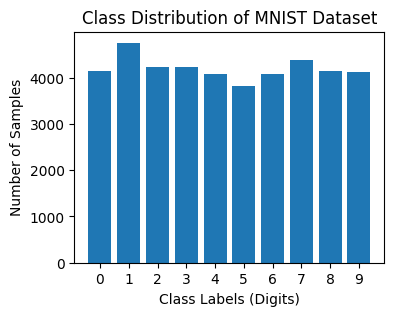

In [18]:
# Bar plot for class distribution
labels = [train_dataset.dataset[i][1] for i in train_dataset.indices]
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(4, 3))
plt.bar(unique, counts)
plt.title('Class Distribution of MNIST Dataset')
plt.xlabel('Class Labels (Digits)')
plt.ylabel('Number of Samples')
plt.xticks(unique)
plt.show()

#### 1.3.4 Principal Component Analysis (PCA) on dataset

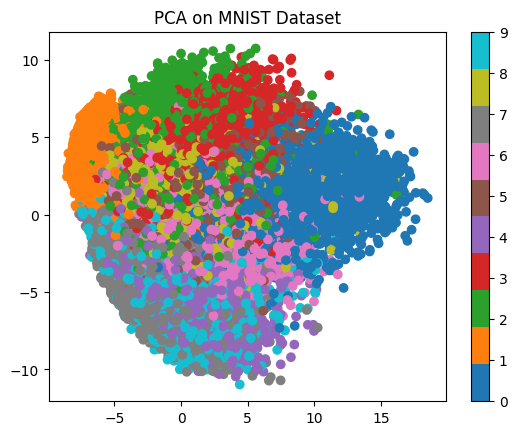

In [20]:
data = torch.stack([train_dataset.dataset[i][0] for i in train_dataset.indices]).view(-1, 28*28).numpy()
labels = torch.tensor([train_dataset.dataset[i][1] for i in train_dataset.indices]).numpy()

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('PCA on MNIST Dataset')
plt.show()

In [21]:
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Testing Samples: {len(test_dataset)}")
print(f"Total Validation Samples: {len(val_dataset)}")
print(f"Image Shape: {train_dataset[0][0].shape}")
print(f"Number of Classes: {len(unique)}")

Total Training Samples: 42000
Total Testing Samples: 14000
Total Validation Samples: 14000
Image Shape: torch.Size([1, 28, 28])
Number of Classes: 10


### 1.4 **Data Augmentation**

#### 1.4.1 Rotating selected images in the dataset to increase the diversity in data

**Procedure**

Define the transformations to rotate the images to left and right by 15 and 5 degrees.
A function is defined to rotate and replace since the same code can be reused for training and testing.
The dataset, no of classes and the portion of data in which we are going to select are used as inputs to the function.
Inside the function, create a dictionary to store the indices of data points belonging to each class.
format of the dictionary will be like {0 :[],1:[]}.
since we are going to rotate to left by 15 and 5 and rotate tight to by 15 and 5 divide the dataset to 4 to avoid any duplicates





In [23]:
random.seed(42)

# Define transformations for rotations
rotate_r15 = transforms.RandomRotation(degrees=(-15, -15))
rotate_r5 = transforms.RandomRotation(degrees=(-5, -5))
rotate_l15 = transforms.RandomRotation(degrees=(5, 5))
rotate_l5 = transforms.RandomRotation(degrees=(15, 15))

# Function to divide, rotate, and replace a portion of images from each class
def rotate_and_replace(dataset, selected_portion):
    data = torch.cat([dataset.dataset[i][0].unsqueeze(0) for i in dataset.indices]).numpy()

    class_indices = {}
    for img_index in range(len(dataset)):
        _, label = dataset[img_index]
        label = int(label.item() if isinstance(label, torch.Tensor) else label)

        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(img_index)

    # Apply rotations
    for indices in class_indices.values():
        num_to_rotate = int(len(indices) * selected_portion)
        selected_indices = random.sample(indices, num_to_rotate)
        quarter_size = num_to_rotate // 4

        for idx in selected_indices[:quarter_size]:
            data[idx] = (rotate_r15(dataset[idx][0]) * 255).byte().numpy()

        for idx in selected_indices[quarter_size:2 * quarter_size]:
            data[idx] = (rotate_r5(dataset[idx][0]) * 255).byte().numpy()

        for idx in selected_indices[2 * quarter_size:3 * quarter_size]:
            data[idx] = (rotate_l15(dataset[idx][0]) * 255).byte().numpy()

        for idx in selected_indices[3 * quarter_size:]:
            data[idx] = (rotate_l5(dataset[idx][0]) * 255).byte().numpy()

    # Update dataset with transformed data
    dataset.data = torch.from_numpy(data)
    return dataset

Apply for the training set

In [24]:
train_dataset = rotate_and_replace(train_dataset, 0.2)
test_dataset = rotate_and_replace(test_dataset, 0.2)
val_dataset = rotate_and_replace(val_dataset, 0.2)

In [25]:
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Testing Samples: {len(test_dataset)}")
print(f"Total Validation Samples: {len(val_dataset)}")

Total Training Samples: 42000
Total Testing Samples: 14000
Total Validation Samples: 14000


Test output after rotating

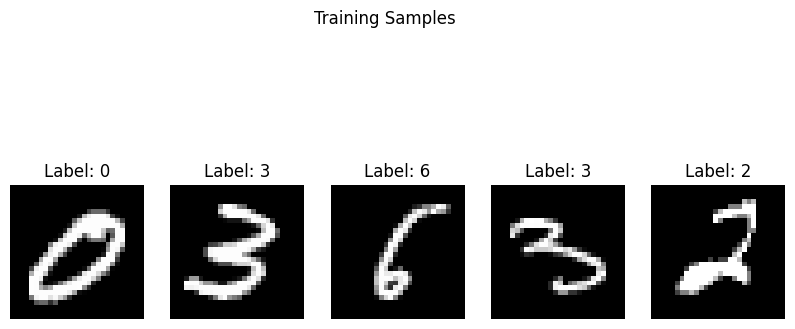

In [33]:
num_samples = 5  # Randomly select indices from the training dataset
train_indices = random.sample(range(len(train_dataset)), num_samples)

train_images = torch.stack([train_dataset[i][0] for i in train_indices])
train_labels = torch.tensor([train_dataset[i][1] for i in train_indices])

plot_samples(train_images[:5], train_labels[:5], class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

## **2. Model Building** 

### **2.1 Model Creation**

##### **Architecture**

The `CustomCNN` class defines a Convolutional Neural Network (CNN) for image classification task

1. First Convolutional Block - Uses 32 filters of size 3x3 to apply a single-channel greyscale image. MaxPooling reduces the spatial dimensions by a factor of 2

2. Second Convolutional Block - Takes the 32-channel input from the previous layer and applies 64 filters of size 3x3. MaxPooling Layer reduces the spatial dimensions further

3. Fully Connected Layer - Flattens feature maps into a fully connected layer with 128 neurons. The dropout layer prevents overfitting.

4. Output Layer - Maps the 128-dimensional input to the number of classes.

#### **Forward Propagation**

The forward propagation method involves applying the first convolutional block, followed by ReLU activation and max pooling. The second convolutional block is applied, followed by ReLU activation and max pooling. The feature maps are flattened into a 1D tensor for the fully connected layer. The fully connected layer is applied, followed by ReLU activation. Dropout is applied to prevent overfitting. The output layer is used to produce class scores and convert them into log-probabilities using the log-softmax function.

In [34]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(CustomCNN, self).__init__()

        # First Convolutional Block - Convolution with 32 filters and MaxPooling
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block - Convolution with 64 filters and MaxPooling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_rate)

        # Final output layer with softmax
        self.fc2 = nn.Linear(128, num_classes)

    #Forward Propagation
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CustomCNN(num_classes=10, dropout_rate=0.5)
print(model)

CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


**Not mandatory to run this below cell** <br/><br/>
Run `pip install torchview` and `sudo apt-get install graphviz`

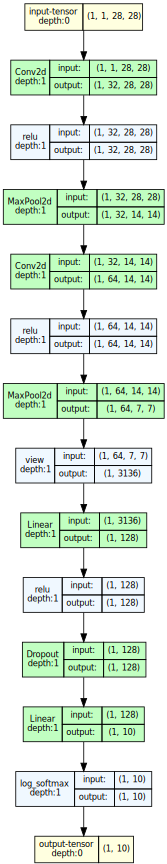

In [35]:
from torchview import draw_graph

example_input = torch.rand(1, 1, 28, 28)  # MNIST images are 28x28 with 1 channel

# Draw the model graph
model_graph = draw_graph(model, example_input, expand_nested=True, graph_name='CustomCNN')
model_graph.visual_graph

### **2.2  Model Training** 


In [36]:
# Check and set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device.")

if device == "cuda":
    print("CUDA is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"__CUDNN VERSION: {torch.backends.cudnn.version()}")
    print(f"__Number of CUDA Devices: {torch.cuda.device_count()}")
    print(f"__CUDA Device Total Memory [GB]: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f}")

Using cuda device.
CUDA is available.
Device name: NVIDIA GeForce RTX 4070 Laptop GPU
__CUDNN VERSION: 90100
__Number of CUDA Devices: 1
__CUDA Device Total Memory [GB]: 8.59


In [37]:
# Hyperparameters
epochs = 20
learning_rate = 0.001

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

#Initialize Losses
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training model
    model.train()
    train_loss = 0.0
    model.to(device)

    # Calculation of training losses
    for images,labels in train_loader:
        optimizer.zero_grad()
        images , labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    # Validating model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
    # Calculation of validation losses
        for images,labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()

    # Average losses for the epoch
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch:{epoch+1}  Training Loss: {train_loss:.4f}  Validation Loss: {val_loss:.4f} ")


Epoch:1  Training Loss: 0.3101  Validation Loss: 0.0700 
Epoch:2  Training Loss: 0.0996  Validation Loss: 0.0540 
Epoch:3  Training Loss: 0.0774  Validation Loss: 0.0444 
Epoch:4  Training Loss: 0.0597  Validation Loss: 0.0402 
Epoch:5  Training Loss: 0.0514  Validation Loss: 0.0392 
Epoch:6  Training Loss: 0.0443  Validation Loss: 0.0400 
Epoch:7  Training Loss: 0.0378  Validation Loss: 0.0403 
Epoch:8  Training Loss: 0.0350  Validation Loss: 0.0394 
Epoch:9  Training Loss: 0.0298  Validation Loss: 0.0343 
Epoch:10  Training Loss: 0.0270  Validation Loss: 0.0338 
Epoch:11  Training Loss: 0.0258  Validation Loss: 0.0377 
Epoch:12  Training Loss: 0.0220  Validation Loss: 0.0425 
Epoch:13  Training Loss: 0.0204  Validation Loss: 0.0436 
Epoch:14  Training Loss: 0.0214  Validation Loss: 0.0411 
Epoch:15  Training Loss: 0.0191  Validation Loss: 0.0411 
Epoch:16  Training Loss: 0.0171  Validation Loss: 0.0476 
Epoch:17  Training Loss: 0.0186  Validation Loss: 0.0410 
Epoch:18  Training Loss

In [39]:
# Save model state
model_path = "models/custom_cnn_model.pth"
torch.save(model.state_dict(), model_path)
print("Model saved!")

# Save training and validation losses
losses_path = "models/losses.pkl"
with open(losses_path, 'wb') as f:
    pickle.dump({'train_losses': train_losses, 'val_losses': val_losses}, f)
print("Training and validation losses saved!")

Model saved!
Training and validation losses saved!


In [ ]:
model_path = "models/custom_cnn_model.pth"
losses_path = "models/losses.pkl"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded from disk, skipping training.")

    if os.path.exists(losses_path):
        with open(losses_path, 'rb') as f:
            losses = pickle.load(f)
            train_losses = losses['train_losses']
            val_losses = losses['val_losses']
        print("Training and validation losses loaded from disk.")
    else:
        print("Losses file not found.")
else:
    print("Model file not found.")

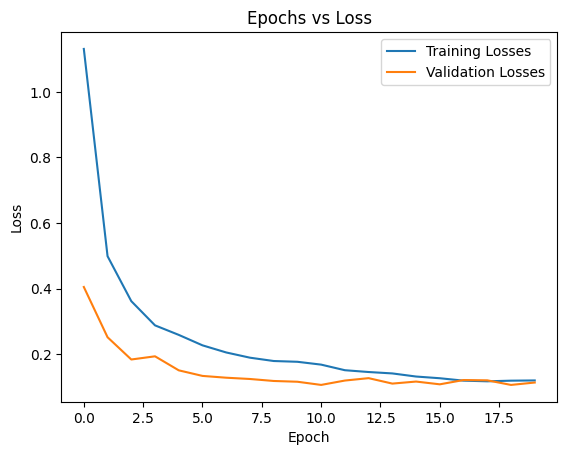

In [ ]:
# Plotting Training and validation losses
plt.plot(train_losses, label  = "Training Losses")
plt.plot(val_losses , label = 'Validation Losses')
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()

### **2.3 Model Evaluation**

In [38]:
from sklearn.metrics import accuracy_score

# Evaluate model on the test dataset
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient tracking for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Store predictions and true labels
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average test loss
test_loss /= len(test_loader)

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds)

# Calculate confusion matrix, precision, and recall
conf_matrix = confusion_matrix(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Test Loss: 0.0400
Test Accuracy: 0.9922
Confusion Matrix:
 [[1370    1    1    0    0    0    4    0    2    1]
 [   0 1568    3    0    1    0    0    2    0    0]
 [   1    0 1355    3    1    0    0    5    0    0]
 [   1    0    3 1445    0    2    0    3    2    1]
 [   0    1    0    0 1388    0    1    0    2    5]
 [   1    0    0    5    0 1282    7    0    2    1]
 [   1    1    0    0    4    0 1378    0    1    0]
 [   0    2    3    1    0    0    0 1425    0    4]
 [   2    0    1    2    2    4    3    2 1356    1]
 [   1    0    0    1    3    2    0    3    3 1324]]
Precision: 0.9922
Recall: 0.9921


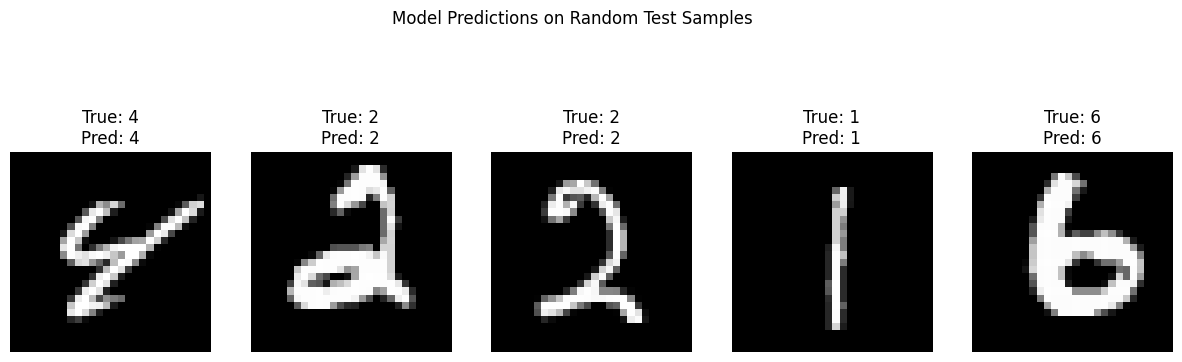

In [39]:
import random

# Function to plot images with true and predicted labels
def plot_predictions(images, true_labels, predicted_labels, class_names, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis('off')

# Select random samples from the test dataset
num_samples = 5
random_indices = random.sample(range(len(test_dataset)), num_samples)
random_images = torch.stack([test_dataset[i][0] for i in random_indices]).to(device)
random_true_labels = torch.tensor([test_dataset[i][1] for i in random_indices])

# Get model predictions for the selected samples
model.eval()
with torch.no_grad():
    random_outputs = model(random_images)
    _, random_predicted_labels = torch.max(random_outputs, 1)

# Plot the images with true and predicted labels
plot_predictions(random_images.cpu().numpy(), random_true_labels.cpu().numpy(), random_predicted_labels.cpu().numpy(), class_names, num_samples=num_samples)
plt.suptitle('Model Predictions on Random Test Samples')
plt.show()


Training with learning rate: 0.0001
Epoch 1, Training Loss: 0.7871, Validation Loss: 0.2282
Epoch 2, Training Loss: 0.2600, Validation Loss: 0.1307
Epoch 3, Training Loss: 0.1760, Validation Loss: 0.0909
Epoch 4, Training Loss: 0.1356, Validation Loss: 0.0757
Epoch 5, Training Loss: 0.1091, Validation Loss: 0.0646
Epoch 6, Training Loss: 0.1012, Validation Loss: 0.0573
Epoch 7, Training Loss: 0.0878, Validation Loss: 0.0552
Epoch 8, Training Loss: 0.0815, Validation Loss: 0.0496
Epoch 9, Training Loss: 0.0734, Validation Loss: 0.0475
Epoch 10, Training Loss: 0.0676, Validation Loss: 0.0448
Epoch 11, Training Loss: 0.0652, Validation Loss: 0.0431
Epoch 12, Training Loss: 0.0585, Validation Loss: 0.0417
Epoch 13, Training Loss: 0.0556, Validation Loss: 0.0426
Epoch 14, Training Loss: 0.0532, Validation Loss: 0.0414
Epoch 15, Training Loss: 0.0497, Validation Loss: 0.0412
Epoch 16, Training Loss: 0.0484, Validation Loss: 0.0385
Epoch 17, Training Loss: 0.0453, Validation Loss: 0.0387
Epo

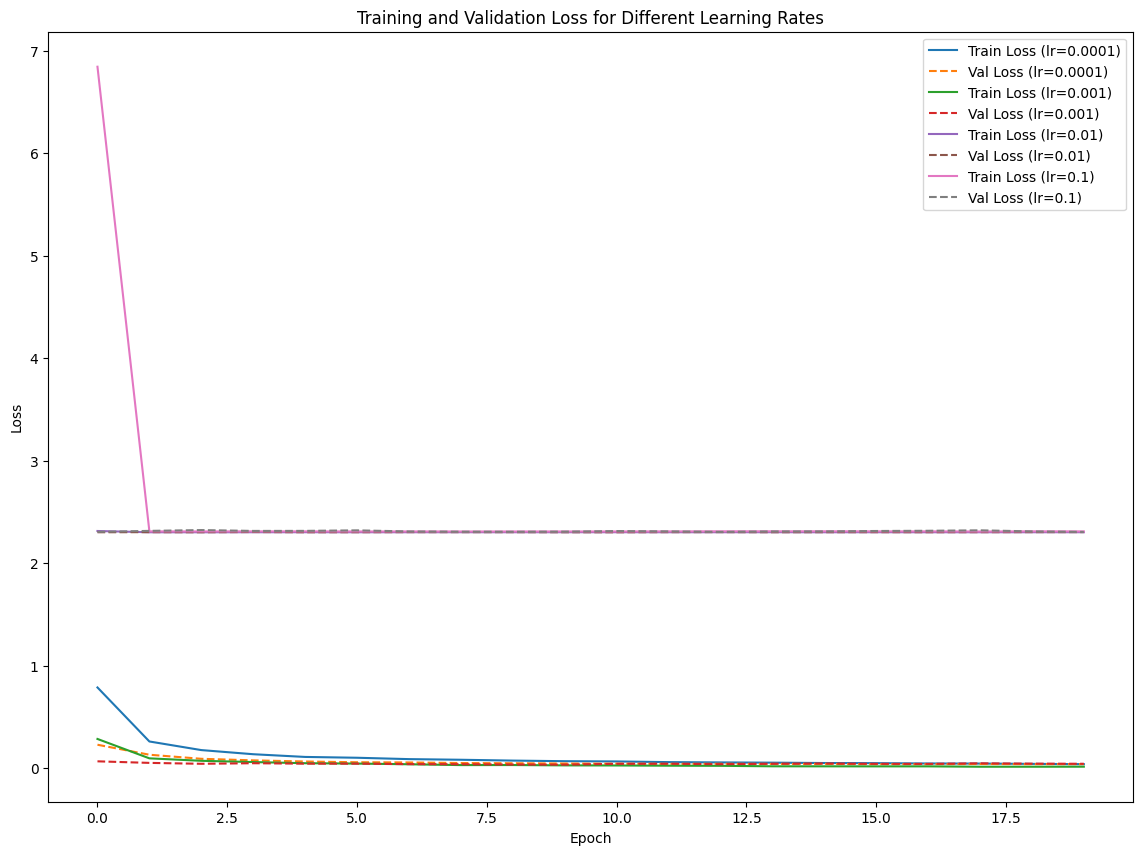

In [42]:
# Define learning rates to test
learning_rates = [0.0001, 0.001, 0.01, 0.1]
epochs = 20
train_losses_all = {}
val_losses_all = {}

# Loop over different learning rates
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    # Reinitialize model and optimizer for each learning rate
    model = CustomCNN(num_classes=10, dropout_rate=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Initialize lists to track losses
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate average training loss for the epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average validation loss for the epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Store the losses for each learning rate
    train_losses_all[lr] = train_losses
    val_losses_all[lr] = val_losses

# Plot training and validation losses for each learning rate
plt.figure(figsize=(14, 10))
for lr in learning_rates:
    plt.plot(train_losses_all[lr], label=f'Train Loss (lr={lr})')
    plt.plot(val_losses_all[lr], linestyle='--', label=f'Val Loss (lr={lr})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Learning Rates')
plt.legend()
plt.show()
